# Extract annotation information from OMIM
## OMIM® - Online Mendelian Inheritance in Man®

To utilize this notebook: 

1. Go to [OMIM database](https://go.drugbank.com/releases/latest) and submit a request to download files.
2. Follow the instructions to obtain download access for MIM files.
3. After receiving access (check email), download the following files:
    * `mim2gene.txt`: A tab-delimited file linking MIM numbers with NCBI Gene IDs, Ensembl Gene IDs, and HGNC Approved Gene Symbols.
    * `mimTitles.txt`A tab-delimited file of MIM numbers and titles.
    * `genemap2.txt`A tab-delimited file containing OMIM's Synopsis of the Human Gene Map including additional information such as genomic coordinates and inheritance.
    * `morbidmap.txt`A tab-delimited file of OMIM's Synopsis of the Human Gene Map (same as `genemap2.txt` above) sorted alphabetically by disorder.
4. Remember clear out any personal account information and ensure the downloaded OMIM file(s) remains local!


### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    get_annotation_df,
    split_string,
    read_rbc_model,
    show_versions,
    build_string,
    compare_tables,
    visualize_comparison,
    GEM_NAME,
)

from rbc_gem_utils.database.mim import (
    MIM_PATH,
    MIM_NUMBER_RE,
    MIM_DB_TAG,
    get_last_updated_dates_MIM,
    load_data_MIM,
)

show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Check OMIM version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 
* Major updates appear to be monthly. See last update [here](https://omim.org/statistics/update).
* Data files are updated nightly.

In [2]:
last_updated = get_last_updated_dates_MIM(f"{ROOT_PATH}{DATABASE_PATH}{MIM_PATH}")

Files last generated on: 2024-02-09


## Load RBC-GEM model

In [3]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,146f0e290
Number of metabolites,1967
Number of reactions,2788
Number of genes,653
Number of groups,74
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


### Determine mapping method
#### Load model annotations of relevance

In [4]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type),
    ["ncbigene", "hgnc.symbol", "ensembl", "mim"],
).rename({"id": annotation_type}, axis=1)

for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].apply(split_string)
    df_model_mappings = df_model_mappings.explode(col)
df_model_mappings = df_model_mappings.drop_duplicates()
print(df_model_mappings.nunique(dropna=True))
df_model_mappings

genes           653
ncbigene        657
hgnc.symbol     654
ensembl         468
mim            1133
dtype: int64


,genes,ncbigene,hgnc.symbol,ensembl,mim
0,RPE,6120,RPE,ENSG00000197713,180480
1,RPIA,22934,RPIA,ENSG00000153574,180430
1,RPIA,22934,RPIA,ENSG00000153574,608611
2,SORD,6652,SORD,ENSG00000140263,618912
2,SORD,6652,SORD,ENSG00000140263,182500
...,...,...,...,...,...
651,GRIA1,2890,GRIA1,NaN,138248
651,GRIA1,2890,GRIA1,NaN,619927
651,GRIA1,2890,GRIA1,NaN,619931
652,A4GALT,53947,A4GALT,ENSG00000128274,111400


## Set notebook options

In [5]:
database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
# Compare to/Overwrite previous files
compare = True
display_nunique = True
overwrite = True
print_footer_notes = False
mapping_key = "ncbigene"

#### Get query IDs

In [6]:
print(f"Mapping key: {mapping_key}")
query_ids = df_model_mappings[mapping_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[
    mapping_key
].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings[[annotation_type, mapping_key]].drop_duplicates()

Mapping key: ncbigene
Number of model genes associated with query: 653
Number of unique IDs to query: 657


,genes,ncbigene
0,RPE,6120
1,RPIA,22934
2,SORD,6652
3,AKR7A2,8574
4,SRM,6723
...,...,...
648,SCD,6319
649,RPS6KA4,8986
650,GCNT2,2651
651,GRIA1,2890


## Load MIM data
### MIM Numbers and types

In [7]:
df_mim = load_data_MIM("mim2gene", print_footer_notes=print_footer_notes).fillna("")
df_mim = df_mim.rename(
    {
        "# MIM Number": "mim",
        "Entrez Gene ID (NCBI)": "ncbigene",
        "Approved Gene Symbol (HGNC)": "hgnc.symbol",
        "Ensembl Gene ID (Ensembl)": "ensembl",
        "MIM Entry Type (see FAQ 1.3 at https://omim.org/help/faq)": "type",
    },
    axis=1,
)
df_mim.head()

,mim,type,ncbigene,hgnc.symbol,ensembl
0,100050,predominantly phenotypes,,,
1,100070,phenotype,100329167,,
2,100100,phenotype,,,
3,100200,predominantly phenotypes,,,
4,100300,phenotype,,,


### Morbid Map

In [8]:
df_morbidmap = load_data_MIM("morbidmap", print_footer_notes=print_footer_notes).fillna(
    ""
)
rename_mapping = {
    "MIM Number": "mim",
    "# Phenotype": "phenotype",
    "Cyto Location": "cyto.location",
}
df_morbidmap = df_morbidmap.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1)
df_morbidmap["mim.phenotype"] = df_morbidmap["phenotype"].apply(
    lambda phenotype: build_string(
        [
            MIM_NUMBER_RE.search(s).group()
            for s in split_string(phenotype, sep=" ")
            if MIM_NUMBER_RE.search(s)
        ]
    )
)
df_morbidmap.head()

,mim,phenotype,cyto.location,mim.phenotype
0,609300,"17,20-lyase deficiency, isolated, 202110 (3)",10q24.32,202110
1,609300,"17-alpha-hydroxylase/17,20-lyase deficiency, 2...",10q24.32,202110
2,615787,"2,4-dienoyl-CoA reductase deficiency, 616034 (3)",5p13.2,616034
3,600301,"2-methylbutyrylglycinuria, 610006 (3)",10q26.13,610006
4,609577,"3-M syndrome 1, 273750 (3)",6p21.1,273750


### Gene Map

In [9]:
df_genemap = load_data_MIM("genemap2", print_footer_notes=print_footer_notes).fillna("")
# # Seperate mouse genes IDs
# df_model_mim_final["Mouse Gene Symbol"] = df_model_mim_final["Mouse Gene Symbol/ID"].fillna("").apply(lambda x: x.split(" ")[0])
# df_model_mim_final["Mouse Gene Symbol"] = df_model_mim_final["Mouse Gene Symbol"].str.replace(",", ";")
df_genemap["Mouse Gene ID"] = (
    df_genemap["Mouse Gene Symbol/ID"]
    .fillna("")
    .apply(lambda x: x.split(" ")[-1].lstrip("(").rstrip(")"))
)
df_genemap["Mouse Gene ID"] = df_genemap["Mouse Gene ID"].str.replace(",", ";")

rename_mapping = {
    "# Chromosome": "chromosome",
    "Cyto Location": "cyto.location",
    "MIM Number": "mim",
    "Approved Gene Symbol": "hgnc.symbol",
    "Entrez Gene ID": "ncbigene",
    "Ensembl Gene ID": "ensemble",
    "Phenotypes": "phenotype",
    "Mouse Gene ID": "mgi",
}
df_genemap = df_genemap.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1)
df_genemap["mim.phenotype"] = df_genemap["phenotype"].apply(
    lambda phenotype: build_string(
        [
            MIM_NUMBER_RE.search(s).group()
            for s in split_string(phenotype, sep=" ")
            if MIM_NUMBER_RE.search(s)
        ]
    )
)
df_genemap.head()

,chromosome,cyto.location,mim,hgnc.symbol,ncbigene,ensemble,phenotype,mgi,mim.phenotype
0,chr1,1p36,607413,,,,,,
1,chr1,1p36,612367,,100196914,,"{Alkaline phosphatase, plasma level of, QTL 2}...",,612367
2,chr1,1p,606788,,171514,,"{Anorexia nervosa, susceptibility to, 1}, 6067...",,606788
3,chr1,1p36,605462,,100307118,,"{Basal cell carcinoma, susceptibility to, 1}, ...",,605462
4,chr1,1p36,606928,,246259,,"[Bone mineral density QTL 3], 606928 (2)",,606928


### Titles

In [10]:
df_mimtitles = load_data_MIM("mimTitles", print_footer_notes=print_footer_notes).fillna(
    ""
)
rename_mapping = {
    "MIM Number": "mim",
    "Preferred Title; symbol": "title",
}
df_mimtitles = df_mimtitles.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1)
df_mimtitles["title"] = df_mimtitles["title"].apply(lambda x: split_string(x))
df_mimtitles["title.symbol"] = df_mimtitles["title"].apply(
    lambda x: x[-1] if len(x) > 1 else ""
)
df_mimtitles["title"] = df_mimtitles["title"].apply(lambda x: x[0])

df_mimtitles.head()

,mim,title,title.symbol
0,100050,"AARSKOG SYNDROME, AUTOSOMAL DOMINANT",
1,100070,"AORTIC ANEURYSM, FAMILIAL ABDOMINAL, 1",AAA1
2,100100,PRUNE BELLY SYNDROME,PBS
3,100200,ABDUCENS PALSY,
4,100300,ADAMS-OLIVER SYNDROME 1,AOS1


## Map to model

In [11]:
df_model_mim = (
    pd.merge(
        df_model_mappings[[annotation_type, mapping_key]].drop_duplicates(),
        df_mim,
        left_on=mapping_key,
        right_on=mapping_key,
        how="left",
        suffixes=("", "_drop"),
    )
    .merge(
        df_morbidmap, left_on="mim", right_on="mim", how="left", suffixes=("", "_drop")
    )
    .merge(
        df_genemap, left_on="mim", right_on="mim", how="left", suffixes=("", "_drop")
    )
    .merge(
        df_mimtitles, left_on="mim", right_on="mim", how="left", suffixes=("", "_drop")
    )
)
df_removed_mim = df_model_mim[df_model_mim["type"] == "moved/removed"]
df_model_mim = df_model_mim[df_model_mim["type"] != "moved/removed"].reset_index(
    drop=True
)
df_model_mim = df_model_mim.drop(
    [c for c in df_model_mim.columns if c.endswith("_drop")], axis=1
).drop_duplicates()
df_model_mim = df_model_mim.replace("", float("nan"))


df_model_mim["mim.all"] = df_model_mim[["mim", "mim.phenotype"]].apply(
    lambda x: build_string(set(x.dropna().unique())), axis=1
)
df_model_mim = df_model_mim[df_model_mim["type"].str.find("gene") == 0]
df_model_mim = df_model_mim.sort_values(annotation_type).reset_index(drop=True)

if overwrite:
    df_model_mim.to_csv(f"{database_dirpath}/{MIM_DB_TAG}_{GEM_NAME}.tsv", sep="\t")
else:
    df_model_mim.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{MIM_DB_TAG}_{GEM_NAME}.tsv", sep="\t"
    )

df_model_mim

,genes,ncbigene,mim,type,hgnc.symbol,ensembl,phenotype,cyto.location,mim.phenotype,chromosome,ensemble,mgi,title,title.symbol,mim.all
0,A4GALT,53947,607922,gene,A4GALT,ENSG00000128274,"[Blood group, P1Pk system, p phenotype], 11140...",22q13.2,111400,chr22,ENSG00000128274,MGI:3512453,"ALPHA-1,4-GALACTOSYLTRANSFERASE",A4GALT,111400;607922
1,A4GALT,53947,607922,gene,A4GALT,ENSG00000128274,"NOR polyagglutination syndrome, 111400 (3)",22q13.2,111400,chr22,ENSG00000128274,MGI:3512453,"ALPHA-1,4-GALACTOSYLTRANSFERASE",A4GALT,111400;607922
2,A4GALT,53947,607922,gene,A4GALT,ENSG00000128274,"[Blood group, P1Pk system, P(2) phenotype], 11...",22q13.2,111400,chr22,ENSG00000128274,MGI:3512453,"ALPHA-1,4-GALACTOSYLTRANSFERASE",A4GALT,111400;607922
3,AARS1,16,601065,gene,AARS1,ENSG00000090861,"Trichothiodystrophy 8, nonphotosensitive, 6196...",16q22.1,619691,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,619691;601065
4,AARS1,16,601065,gene,AARS1,ENSG00000090861,"?Leukoencephalopathy, hereditary diffuse, with...",16q22.1,619661,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,619661;601065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,YARS1,8565,603623,gene,YARS1,ENSG00000134684,"Charcot-Marie-Tooth disease, dominant intermed...",1p35.1,608323,chr1,ENSG00000134684,MGI:2147627,TYROSYL-tRNA SYNTHETASE 1,YARS1,608323;603623
864,ZDHHC2,51201,618621,gene,ZDHHC2,ENSG00000104219,NaN,NaN,NaN,chr8,ENSG00000104219,MGI:1923452,ZINC FINGER DHHC-TYPE PALMITOYLTRANSFERASE 2,ZDHHC2,618621
865,ZDHHC20,253832,617972,gene,ZDHHC20,ENSG00000180776,NaN,NaN,NaN,chr13,ENSG00000180776,MGI:1923215,ZINC FINGER DHHC DOMAIN-CONTAINING PROTEIN 20,ZDHHC20,617972
866,ZDHHC3,51304,617150,gene,ZDHHC3,ENSG00000163812,NaN,NaN,NaN,chr3,ENSG00000163812,MGI:1926134,ZINC FINGER DHHC DOMAIN-CONTAINING PROTEIN 3,ZDHHC3,617150


In [12]:
df_annotations = df_model_mim.loc[
    :, ["genes", "mim.all", "ncbigene", "hgnc.symbol", "ensembl", "mgi"]
]
df_annotations = df_annotations.rename({"mim.all": "mim"}, axis=1)
df_annotations = df_annotations.drop_duplicates().reset_index(drop=True)
df_annotations = df_annotations.groupby("genes").agg(
    lambda x: build_string(sorted(x.dropna()))
)

genes: 646
mim: 1133
ncbigene: 647
hgnc.symbol: 647
ensembl: 646
mgi: 685


,genes,mim,ncbigene,hgnc.symbol,ensembl,mgi
0,A4GALT,111400;607922,53947,A4GALT,ENSG00000128274,MGI:3512453
1,AARS1,613287;601065;616339;601065;619661;601065;6196...,16,AARS1,ENSG00000090861,MGI:2384560
2,AASDHPPT,607756,60496,AASDHPPT,ENSG00000149313,MGI:1914868
3,ABCA1,205400;600046;604091;600046,19,ABCA1,ENSG00000165029,MGI:99607
4,ABCA7,608907;605414,10347,ABCA7,ENSG00000064687,MGI:1351646
...,...,...,...,...,...,...
641,YARS1,603623;619418;608323;603623,8565,YARS1,ENSG00000134684,MGI:2147627
642,ZDHHC2,618621,51201,ZDHHC2,ENSG00000104219,MGI:1923452
643,ZDHHC20,617972,253832,ZDHHC20,ENSG00000180776,MGI:1923215
644,ZDHHC3,617150,51304,ZDHHC3,ENSG00000163812,MGI:1926134


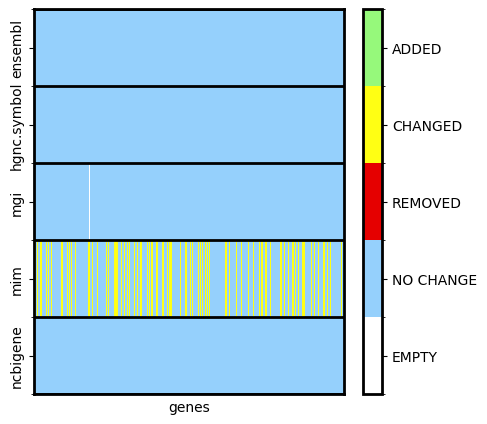

In [13]:
df_annotations = df_model_mim.loc[
    :, ["genes", "mim.all", "ncbigene", "hgnc.symbol", "ensembl", "mgi"]
]
df_annotations = df_annotations.rename({"mim.all": "mim"}, axis=1)
df_annotations = df_annotations.drop_duplicates().reset_index(drop=True)
df_annotations = df_annotations.groupby("genes").agg(
    lambda x: build_string(sorted(x.dropna()))
)
df_annotations = df_annotations.reset_index(drop=False).drop_duplicates()
df_annotations = df_annotations.replace("", float("nan"))

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{MIM_DB_TAG}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )

        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{MIM_DB_TAG}.tsv", sep="\t"
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{MIM_DB_TAG}.tsv", sep="\t"
    )
df_annotations